# Is French Wine Overpriced?
## With this data, your goal is to assess whether French Wine is overpriced, relative to similar wines of similar quality from different countries.

## Reading in relevant packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize ,
                         poly)
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Reading in the data

In [2]:
wines = pd.read_csv("wines.csv")
wines.columns

Index(['price', 'points', 'variety', 'country', 'province', 'description',
       'review_sentiment', 'wine_color'],
      dtype='object')

There are no NaN values in the dataset, so no variables need to be removed

In [3]:
wines.isna().sum()

price               0
points              0
variety             0
country             0
province            0
description         0
review_sentiment    0
wine_color          0
dtype: int64

In [4]:
wines['country'].unique()

array(['US', 'Italy', 'France', 'Chile', 'Spain'], dtype=object)

To ensure computational efficiency, a random sub-sample of 3000 observations has been selected, whilst ensuring that there is a wine from at least the US, France, Italy, and Chile in this sample.

In [5]:
import pandas as pd

# Load the dataset
# wines = pd.read_csv('path_to_your_wines_dataset.csv')  # Uncomment and modify this line to load your dataset

# Ensure there is at least one wine from the US, France, Italy, and Chile
countries_to_include = ['US', 'France', 'Italy', 'Chile']
filtered_wines = wines[wines['country'].isin(countries_to_include)]

# Ensure the number of unique countries in the filtered dataset
print(filtered_wines['country'].unique())

# Calculate the number of additional samples needed
n_filtered_wines = len(filtered_wines)
n_additional_samples = max(3000 - n_filtered_wines, 0)

if n_additional_samples > 0:
    # Remove these specific wines from the original dataset
    remaining_wines = wines[~wines.index.isin(filtered_wines.index)]

    # Randomly sample the remaining wines to reach 3000 observations
    additional_samples = remaining_wines.sample(n=n_additional_samples, random_state=1)

    # Combine the filtered wines with the additional samples
    sampled_wines = pd.concat([filtered_wines, additional_samples])
else:
    # If the filtered wines are already more than 3000, sample 3000 from them
    sampled_wines = filtered_wines.sample(n=3000, random_state=1)

# Verify the size and the presence of each country
print(sampled_wines.shape)
print(sampled_wines['country'].value_counts())

# Now, `sampled_wines` contains the desired subset of the data



['US' 'Italy' 'France' 'Chile']
(3000, 8)
US        2187
France     393
Italy      213
Chile      207
Name: country, dtype: int64


In [6]:
sampled_wines.columns

Index(['price', 'points', 'variety', 'country', 'province', 'description',
       'review_sentiment', 'wine_color'],
      dtype='object')

The decision has been made to remove the **description** variable, as the **review_sentiment** variable is the product of a text mining method that takes into account these review descriptions anyway!

In [7]:
sampled_wines = sampled_wines.drop(['description'],
                   axis=1)

In [8]:
sampled_wines.columns

Index(['price', 'points', 'variety', 'country', 'province', 'review_sentiment',
       'wine_color'],
      dtype='object')

## Model Criticism Lab

Looking at the continous variables

/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


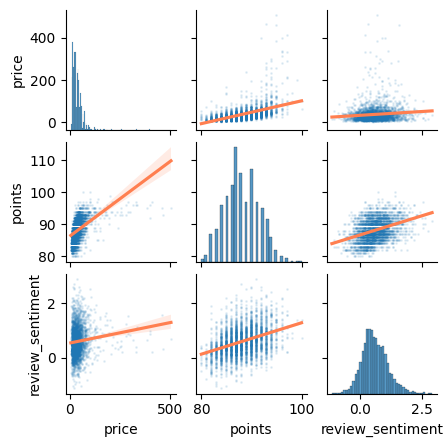

In [9]:
import seaborn
seaborn.pairplot(
data=sampled_wines,
kind="reg",
plot_kws=dict(scatter_kws=dict(s=1, alpha=0.1), line_kws=dict(color="coral")),
size=1.5,
)

From the plots above, there seems to be strange distributions in relation to price. Price seems to be positively skewed and could possibly benefit from undergoing a log transformation.

In [10]:
# Log transform the 'price' variable
sampled_wines['price'] = np.log(sampled_wines['price'])

Checking that the transformation has been effective.

/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


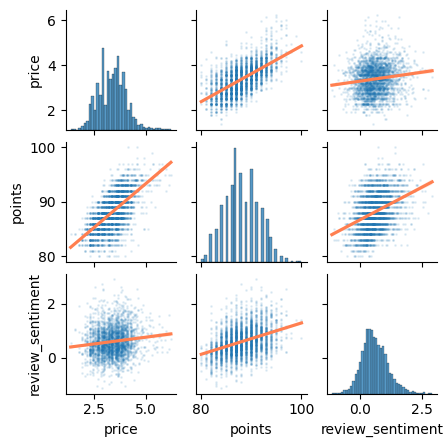

In [11]:
import seaborn
seaborn.pairplot(
data=sampled_wines,
kind="reg",
plot_kws=dict(scatter_kws=dict(s=1, alpha=0.1), line_kws=dict(color="coral")),
size=1.5,
)

The plots show normally distributed continous variables, and therefore the data is ready for modelling

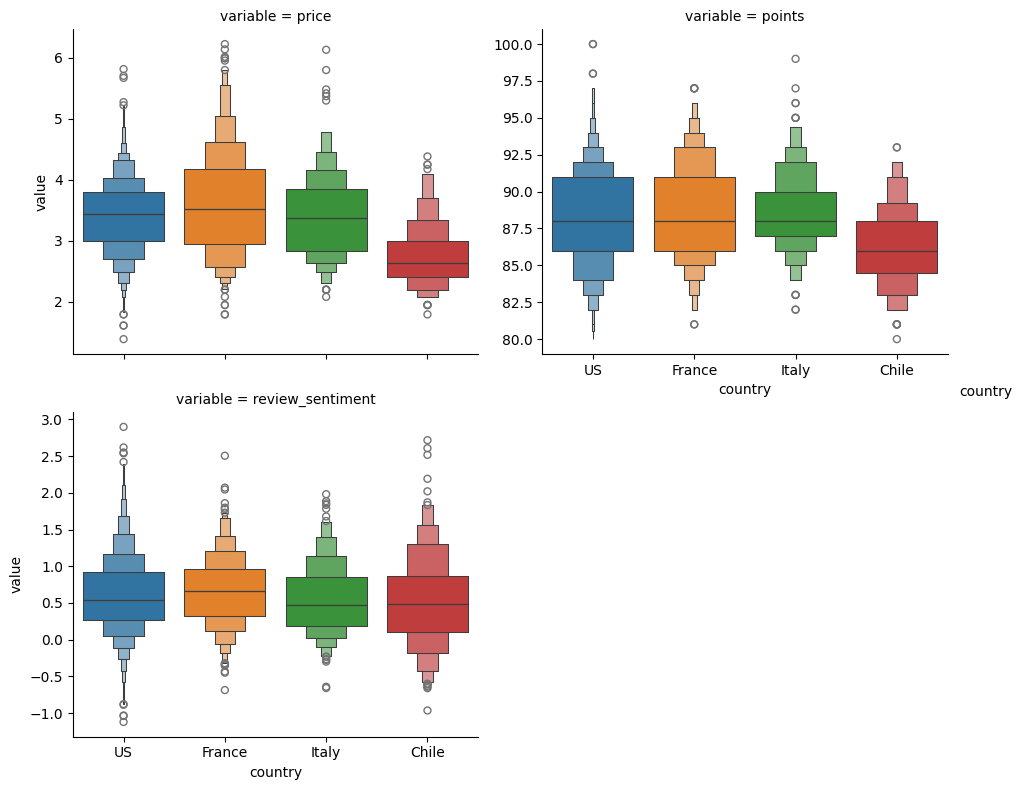

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Select relevant columns
wines_continuous = sampled_wines[['country', 'price', 'points', 'review_sentiment']]

# Melt the dataframe to long format for Seaborn catplot
wines_melted = wines_continuous.melt(id_vars="country")

# Plot using Seaborn catplot
sns.catplot(
    data=wines_melted,
    x="country",
    hue="country",
    y="value",
    col="variable",
    col_wrap=2,
    sharey=False,
    kind="boxen",
    height=4,
    aspect=1.21,
)

# Display the plot
plt.show()


/var/folders/4v/3lt6t9r90bs_k0p4vlxnqccw0000gn/T/ipykernel_23902/4080932215.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = wines_continuous.corr()


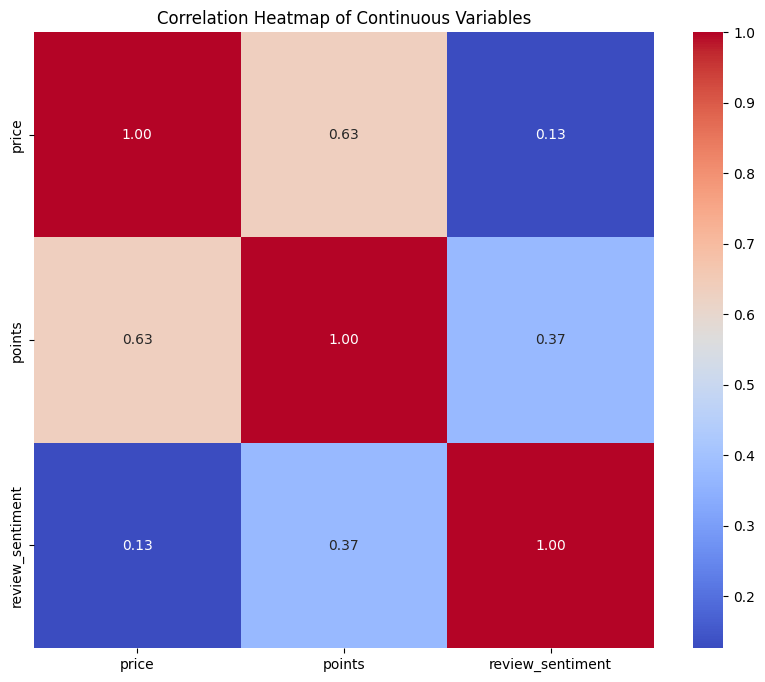

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Compute the correlation matrix
corr_matrix = wines_continuous.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Continuous Variables')
plt.show()

## Understanding predicitons with scenarios

In [14]:
sampled_wines.columns

Index(['price', 'points', 'variety', 'country', 'province', 'review_sentiment',
       'wine_color'],
      dtype='object')

country       0
variety       0
wine_color    0
price         0
dtype: int64
Shape of X: (3000, 18)
Shape of y: (3000,)
points                          int64
review_sentiment              float64
country_Chile                 float64
country_France                float64
country_Italy                 float64
country_US                    float64
variety_Cabernet Sauvignon    float64
variety_Champagne Blend       float64
variety_Chardonnay            float64
variety_Merlot                float64
variety_Pinot Noir            float64
variety_Red Blend             float64
variety_Rosé                  float64
variety_Sauvignon Blanc       float64
variety_Syrah                 float64
wine_color_red                float64
wine_color_rosé               float64
wine_color_white              float64
dtype: object
Linear Regression Mean Squared Error: 0.20096562615912905


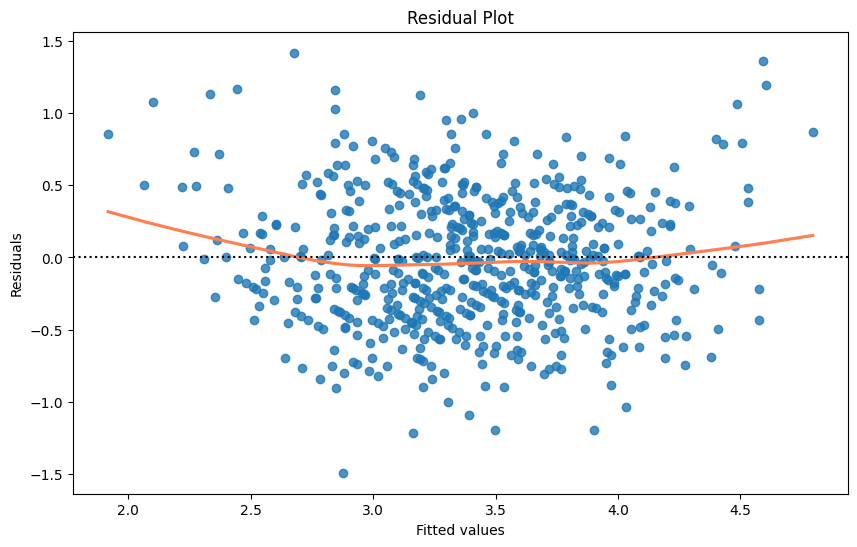

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the sampled_wines DataFrame is already loaded

# Check for missing values in relevant columns
print(sampled_wines[['country', 'variety', 'wine_color', 'price']].isnull().sum())

# Drop rows with missing values in the relevant columns
sampled_wines.dropna(subset=['country', 'variety', 'wine_color', 'price'], inplace=True)

# One-hot encode categorical variables excluding 'province'
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_vars = encoder.fit_transform(sampled_wines[['country', 'variety', 'wine_color']])
encoded_df = pd.DataFrame(encoded_vars, columns=encoder.get_feature_names_out(['country', 'variety', 'wine_color']))

# Ensure indices align
encoded_df.index = sampled_wines.index

# Concatenate the encoded variables with the original DataFrame and drop the original categorical columns including 'province'
sampled_wines_encoded = pd.concat([sampled_wines, encoded_df], axis=1).drop(['country', 'variety', 'wine_color', 'province'], axis=1)

# Select continuous features and drop 'province' along with other categorical variables
X_continuous = sampled_wines.drop(["price", "variety", "country", "wine_color", "province"], axis=1)
X = pd.concat([X_continuous, encoded_df], axis=1)
y = sampled_wines['price']

# Check the shapes of the data
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

# Ensure all features are numerical
print(X.dtypes)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize and fit the MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predict on validation set
linear_preds = linear_model.predict(X_valid_scaled)

# Calculate and print the mean squared error
mse = mean_squared_error(y_valid, linear_preds)
print(f'Linear Regression Mean Squared Error: {mse}')

# Plotting the results
plt.figure(figsize=(10, 6))
sns.regplot(x=linear_preds, y=y_valid - linear_preds, lowess=True, line_kws={'color': 'coral'})
plt.axhline(0, color='k', linestyle=':')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()



In [19]:
import pandas as pd
import numpy as np

# Assuming the models are already trained

# Get the list of countries
countries = sampled_wines['country'].unique()

# Create a DataFrame to store the predicted prices for each country
country_price_predictions = pd.DataFrame(columns=['country', 'predicted_price'])

# Set a constant quality (mean value of points)
constant_quality = sampled_wines['points'].mean()

# Displaying the table similar to your example
test_grid_example = pd.DataFrame([X_train.mean()], columns=X_train.columns)
test_grid_example['points'] = constant_quality
for col in X_train.columns:
    if col.startswith('country_') or col.startswith('variety_') or col.startswith('wine_color_'):
        test_grid_example[col] = 0

# Set the current country to 1 and all other countries to 0 for the example
country_col_example = f'country_{countries[0]}'  # Just an example with the first country
if country_col_example in test_grid_example.columns:
    test_grid_example[country_col_example] = 1

# Display the test grid
print(test_grid_example.head())

# Now predicting for all countries
for country in countries:
    # Create a test grid with all features set to their mean values
    test_grid = pd.DataFrame([X_train.mean()], columns=X_train.columns)
    
    # Set the quality constant
    test_grid['points'] = constant_quality
    
    # Set the current country to 1 and all other categorical variables to 0
    for col in X_train.columns:
        if col.startswith('country_') or col.startswith('variety_') or col.startswith('wine_color_'):
            test_grid[col] = 0
    country_col = f'country_{country}'
    if country_col in test_grid.columns:
        test_grid[country_col] = 1
    
    # Predict the price using the pre-trained linear model
    predicted_price = linear_model.predict(test_grid)[0]
    
    # Store the result
    country_price_predictions = country_price_predictions.append({
        'country': country,
        'predicted_price': predicted_price
    }, ignore_index=True)

# Display the predicted prices for each country
print(country_price_predictions)


      points  review_sentiment  country_Chile  country_France  country_Italy  \
0  88.104667          0.601276              0               0              0   

   country_US  variety_Cabernet Sauvignon  variety_Champagne Blend  \
0           1                           0                        0   

   variety_Chardonnay  variety_Merlot  variety_Pinot Noir  variety_Red Blend  \
0                   0               0                   0                  0   

   variety_Rosé  variety_Sauvignon Blanc  variety_Syrah  wine_color_red  \
0             0                        0              0               0   

   wine_color_rosé  wine_color_white  
0                0                 0  
  country  predicted_price
0      US    -6.983738e+11
1  France    -6.983738e+11
2   Italy    -6.983738e+11
3   Chile    -6.983738e+11


/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/var/folders/4v/3lt6t9r90bs_k0p4vlxnqccw0000gn/T/ipykernel_23902/2718107461.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  country_price_predictions = country_price_predictions.append({
/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/var/folders/4v/3lt6t9r90bs_k0p4vlxnqccw0000gn/T/ipykernel_23902/2718107461.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  country_price_predictions = country_price_predictions.append({
/Users/olivermorgan/anaconda3/lib/python3.11/site-packages/sklearn/b

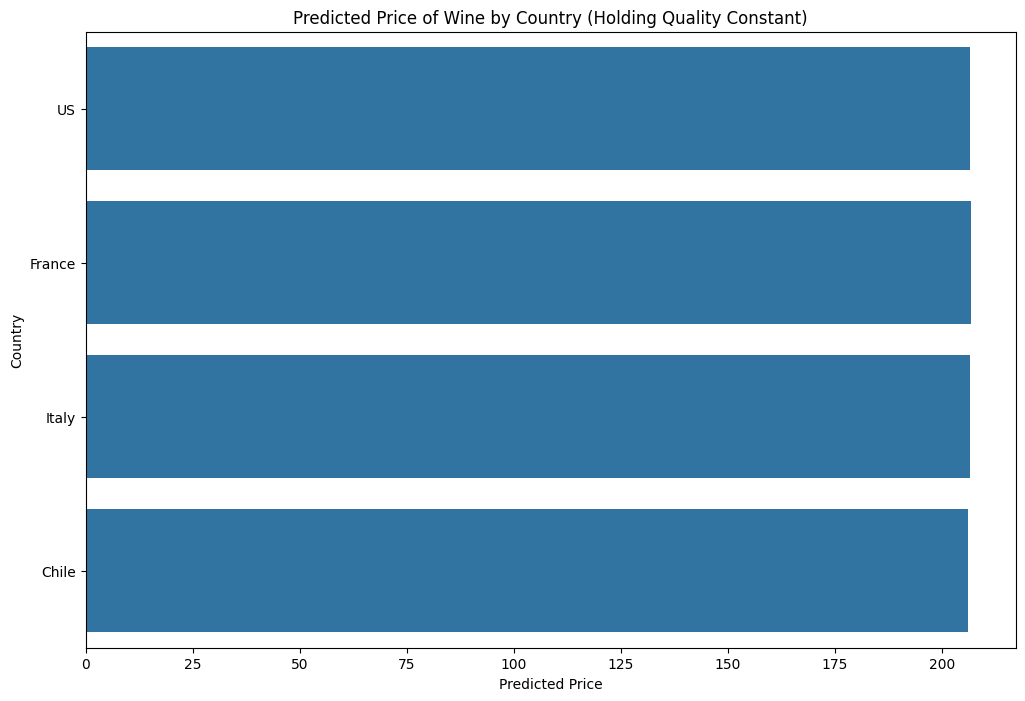

In [18]:
plt.figure(figsize=(12, 8))
sns.barplot(x='predicted_price', y='country', data=country_price_predictions)
plt.title('Predicted Price of Wine by Country (Holding Quality Constant)')
plt.xlabel('Predicted Price')
plt.ylabel('Country')
plt.show()


In [ ]:
bjbjbj

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the wines DataFrame is already loaded

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_vars = encoder.fit_transform(wines[['country', 'variety', 'wine_color']])
encoded_df = pd.DataFrame(encoded_vars, columns=encoder.get_feature_names_out(['country', 'variety', 'wine_color']))
wines_encoded = pd.concat([wines, encoded_df], axis=1).drop(['country', 'variety', 'wine_color'], axis=1)

# Select continuous features and set the target variable 'price'
X_continuous = wines.drop(["price", "variety", "country", "wine_color"], axis=1)
X = pd.concat([X_continuous, encoded_df], axis=1)
y = wines['price']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Initialize and fit the KNN model
knn_model = KNeighborsRegressor(n_neighbors=20)
knn_model.fit(X_train, y_train)

# Create a test grid for points
test_grid = pd.DataFrame(np.arange(wines['points'].min(), wines['points'].max(), 1), columns=["points"])

# Set constant values for other variables
mean_values = X_train.mean()
for col in mean_values.index:
    if col != 'points':
        test_grid[col] = mean_values[col]

# Ensure one-hot encoded variables are set to 0
for col in X_train.columns:
    if col.startswith('country_') or col.startswith('variety_') or col.startswith('wine_color_'):
        test_grid[col] = 0

# Ensure the order of columns matches
test_grid = test_grid[X_train.columns]

# Predict prices using the pre-trained linear model
linear_preds = linear_model.predict(test_grid)

# Predict prices using the pre-trained KNN model
knn_preds = knn_model.predict(test_grid)

# Plotting the relationship between points and predicted price
plt.figure(figsize=(10, 6))

# Scatter plot of the original data
plt.scatter(X_train['points'], y_train, marker=".", color="k", alpha=0.2, label='Training Data')

# Plot predictions
plt.plot(test_grid['points'], knn_preds, color="lime", linewidth=2, label="KNN Model")
plt.plot(test_grid['points'], linear_preds, color="red", linewidth=2, label="Linear Model")

# Labels and title
plt.xlabel("Points")
plt.ylabel("Predicted Price")
plt.title("Predicted Price for Wines Using Linear and KNN Models")

# Legends and grid
plt.legend(frameon=False)
plt.grid(True)
sns.despine()

# Show plot
plt.show()


ValueError: could not convert string to float: 'Colchagua Valley'

In [ ]:
test_grid.head()

In [ ]:
# Calculate residuals for linear model
linear_preds_full = linear_model.predict(X)
linear_residual = y - linear_preds_full

In [ ]:
# Plot residuals for linear model
plt.figure(figsize=(10, 6))
sns.regplot(x=linear_preds_full, y=linear_residual, lowess=True, line_kws=dict(color="coral"))
plt.axhline(0, color="k", linestyle=":")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Linear Model")
plt.show()

In [ ]:
kkjkj
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the wines DataFrame is already loaded

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_vars = encoder.fit_transform(wines[['country', 'variety', 'wine_color']])
encoded_df = pd.DataFrame(encoded_vars, columns=encoder.get_feature_names_out(['country', 'variety', 'wine_color']))
wines_encoded = pd.concat([wines, encoded_df], axis=1).drop(['country', 'variety', 'wine_color'], axis=1)

# Select continuous features and set the target variable 'price'
X_continuous = wines.drop(["price", "variety", "country", "wine_color"], axis=1)
X = pd.concat([X_continuous, encoded_df], axis=1)
y = wines['price']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Initialize and fit the KNN model
knn_model = KNeighborsRegressor(n_neighbors=20)
knn_model.fit(X_train, y_train)

# Create a test grid for points
test_grid = pd.DataFrame(np.arange(wines['points'].min(), wines['points'].max(), 1), columns=["points"])

# Set constant values for other variables
mean_values = X_train.mean()
for col in mean_values.index:
    if col != 'points':
        test_grid[col] = mean_values[col]

# Ensure other country columns are set to 0
for col in X_train.columns:
    if col.startswith('country_'):
        test_grid[col] = 0

# Ensure the order of columns matches
test_grid = test_grid[X_train.columns]

# Predict prices using the pre-trained linear model
linear_preds = linear_model.predict(test_grid)

# Predict prices using the pre-trained KNN model
knn_preds = knn_model.predict(test_grid)

# Plotting the relationship between points and predicted price
plt.figure(figsize=(10, 6))

# Scatter plot of the original data
plt.scatter(X_train['points'], y_train, marker=".", color="k", alpha=0.2, label='Training Data')

# Plot predictions
plt.plot(test_grid['points'], knn_preds, color="lime", linewidth=2, label="KNN Model")
plt.plot(test_grid['points'], linear_preds, color="red", linewidth=2, label="Linear Model")

# Labels and title
plt.xlabel("Points")
plt.ylabel("Predicted Price")
plt.title("Predicted Price for Wines Using Linear and KNN Models")

# Legends and grid
plt.legend(frameon=False)
plt.grid(True)
sns.despine()

# Show plot
plt.show()


In [ ]:
test_grid.head()

In [ ]:
linear_preds = linearmodel.predict(test_grid)
knn_preds = knnmodel.predict(test_grid)

**Standardising and normalisation**

Linear regression assumes a normal distribution for the variables. This is only relevant for numerical variables and therefore these are checked.

In [ ]:
nnknk #Grouping the numerical variables
numerical_columns = ['price', 'review_sentiment', 'points']

In [ ]:
 #Plotting the distribution of values for each variable
wines[numerical_columns].hist(figsize=(10,11));

From inspection, the **price** variable is positively skewed, and therefore it is likely to benefit from log transformation

In [ ]:
# Log transform the 'price' variable
wines['price'] = np.log(wines['price'])

In [ ]:
 #Plotting the distribution of values for each variable
wines[numerical_columns].hist(figsize=(10,11));

The log transformation appears to be successful, as the **price** variable displays a normal distrbution.

Now that the numerical variables have been processed, the remaininig variable can be one-hot encoded

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the wines DataFrame is already loaded

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_vars = encoder.fit_transform(wines[['country', 'variety', 'wine_color']])
encoded_df = pd.DataFrame(encoded_vars, columns=encoder.get_feature_names_out(['country', 'variety', 'wine_color']))
wines_encoded = pd.concat([wines, encoded_df], axis=1).drop(['country', 'variety', 'wine_color'], axis=1)

# Select continuous features and set the target variable 'price'
X_continuous = wines.drop(["price", "variety", "country", "wine_color"], axis=1)
X = pd.concat([X_continuous, encoded_df], axis=1)
y = wines['price']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Initialize and fit the KNN model
knn_model = KNeighborsRegressor(n_neighbors=20)
knn_model.fit(X_train, y_train)

# Create a test grid for points
test_grid = pd.DataFrame(np.arange(wines['points'].min(), wines['points'].max(), 1), columns=["points"])

# Set constant values for other variables
mean_values = X_train.mean()
for col in mean_values.index:
    if col != 'points':
        test_grid[col] = mean_values[col]

# Ensure other country columns are set to 0
for col in X_train.columns:
    if col.startswith('country_'):
        test_grid[col] = 0

# Ensure the order of columns matches
test_grid = test_grid[X_train.columns]

# Predict prices using the pre-trained linear model
linear_preds = linear_model.predict(test_grid)

# Predict prices using the pre-trained KNN model
knn_preds = knn_model.predict(test_grid)

# Plotting the relationship between points and predicted price
plt.figure(figsize=(10, 6))

# Scatter plot of the original data
plt.scatter(X_train['points'], y_train, marker=".", color="k", alpha=0.2, label='Training Data')

# Plot predictions
plt.plot(test_grid['points'], knn_preds, color="lime", linewidth=2, label="KNN Model")
plt.plot(test_grid['points'], linear_preds, color="red", linewidth=2, label="Linear Model")

# Labels and title
plt.xlabel("Points")
plt.ylabel("Predicted Price")
plt.title("Predicted Price for Wines Using Linear and KNN Models")

# Legends and grid
plt.legend(frameon=False)
plt.grid(True)
sns.despine()

# Show plot
plt.show()


In [ ]:
nnknknk
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_vars = encoder.fit_transform(wines[['country', 'variety', 'wine_color']])

# Add encoded variables to the dataset
encoded_df = pd.DataFrame(encoded_vars, columns=encoder.get_feature_names_out(['country', 'variety', 'wine_color']))
wines = pd.concat([wines, encoded_df], axis=1).drop(['country', 'variety', 'wine_color'], axis=1)

# Standardize numerical variables
scaler = StandardScaler()
wines[['review_sentiment']] = scaler.fit_transform(wines[['review_sentiment']])

# Split the data into training and validation sets
X = wines.drop('price', axis=1)
y = wines['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on validation set
linear_pred = linear_model.predict(X_valid)

# Initialize and fit the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict on validation set
knn_pred = knn_model.predict(X_valid)

# Create a test grid for review_sentiment
test_grid = pd.DataFrame(np.linspace(wines['review_sentiment'].min(), wines['review_sentiment'].max(), 100), columns=["review_sentiment"])

# Ensure the test_grid has the same structure as the training set
for col in X_train.columns:
    if col not in test_grid.columns:
        if col == 'country_France':
            test_grid[col] = 1
        else:
            test_grid[col] = 0

# Transform the test grid with the same scaler used in training
scaled_test_grid = scaler.transform(test_grid[['review_sentiment']])

# Ensure other columns are in the correct format
scaled_test_grid = np.hstack([scaled_test_grid, test_grid.drop('review_sentiment', axis=1).values])

# Predict prices using the pre-trained linear model
linear_preds = linear_model.predict(scaled_test_grid)

# Predict prices using the pre-trained KNN model
knn_preds = knn_model.predict(scaled_test_grid)

# Plotting the relationship between review_sentiment and predicted price
plt.figure(figsize=(10, 6))

# Scatter plot of the original data
plt.scatter(X_train['review_sentiment'], y_train, marker=".", color="k", alpha=0.2, label='Training Data')

# Plot predictions
plt.plot(test_grid['review_sentiment'], knn_preds, color="lime", linewidth=2, label="KNN Model")
plt.plot(test_grid['review_sentiment'], linear_preds, color="red", linewidth=2, label="Linear Model")

# Labels and title
plt.xlabel("Review Sentiment")
plt.ylabel("Predicted Price")
plt.title("Predicted Price for Two Models")

# Legends and grid
plt.legend(frameon=False)
plt.grid(True)
sns.despine()

# Show plot
plt.show()


In [ ]:
bbmmbm

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_vars = encoder.fit_transform(wines[['country', 'variety', 'wine_color']])

# Add encoded variables to the dataset
encoded_df = pd.DataFrame(encoded_vars, columns=encoder.get_feature_names_out(['country', 'variety', 'wine_color']))
wines = pd.concat([wines, encoded_df], axis=1).drop(['country', 'variety', 'wine_color'], axis=1)

# Standardize numerical variables
scaler = StandardScaler()
wines[['review_sentiment']] = scaler.fit_transform(wines[['review_sentiment']])

# Split the data into training and validation sets
X = wines.drop('price', axis=1)
y = wines['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on validation set
linear_pred = linear_model.predict(X_valid)

# Calculate MSE and R²
linear_mse = mean_squared_error(y_valid, linear_pred)
linear_r2 = r2_score(y_valid, linear_pred)
print(f"Linear Regression MSE: {linear_mse}, R²: {linear_r2}")


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize and fit the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict on validation set
knn_pred = knn_model.predict(X_valid)

# Calculate MSE and R²
knn_mse = mean_squared_error(y_valid, knn_pred)
knn_r2 = r2_score(y_valid, knn_pred)
print(f"KNN Regression MSE: {knn_mse}, R²: {knn_r2}")


In [ ]:
import numpy as np

# Create a test grid for review_sentiment
test_grid = pd.DataFrame(np.linspace(wines['review_sentiment'].min(), wines['review_sentiment'].max(), 100), columns=["review_sentiment"])

# Ensure the test_grid has the same structure as the training set
for col in X_train.columns:
    if col not in test_grid.columns:
        if col == 'country_France':
            test_grid[col] = 1
        else:
            test_grid[col] = 0

# Transform the test grid with the same scaler used in training
scaled_test_grid = scaler.transform(test_grid[['review_sentiment']])

# Ensure other columns are in the correct format
scaled_test_grid = np.hstack([scaled_test_grid, test_grid.drop('review_sentiment', axis=1).values])


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Predict prices using the pre-trained linear model
linear_preds = linear_model.predict(scaled_test_grid)

# Predict prices using the pre-trained KNN model
knn_preds = knn_model.predict(scaled_test_grid)

# Add predictions to test grid for plotting
test_grid['linear_pred'] = linear_preds
test_grid['knn_pred'] = knn_preds

# Plotting the relationship between review_sentiment and predicted price using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_sentiment', y='linear_pred', data=test_grid, label='Linear Model', color='red')
sns.scatterplot(x='review_sentiment', y='knn_pred', data=test_grid, label='KNN Model', color='blue')
plt.xlabel('Review Sentiment')
plt.ylabel('Predicted Price')
plt.title('Relationship between Review Sentiment and Predicted Price for French Wines')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
nnnk

In [ ]:
jkjkjimport pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_vars = encoder.fit_transform(wines[['country', 'variety', 'wine_color']])

# Add encoded variables to the dataset
encoded_df = pd.DataFrame(encoded_vars, columns=encoder.get_feature_names_out(['country', 'variety', 'wine_color']))
wines = pd.concat([wines, encoded_df], axis=1).drop(['country', 'variety', 'wine_color'], axis=1)

# Standardize numerical variables
scaler = StandardScaler()
wines[['review_sentiment']] = scaler.fit_transform(wines[['review_sentiment']])

# Split the data into training and validation sets
X = wines.drop('price', axis=1)
y = wines['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)


In [ ]:
import numpy as np

# Create a test grid for review_sentiment
test_grid = pd.DataFrame(np.linspace(wines['review_sentiment'].min(), wines['review_sentiment'].max(), 100), columns=["review_sentiment"])

# Ensure the test_grid has the same structure as the training set
for col in X_train.columns:
    if col not in test_grid.columns:
        if col.startswith('country_France'):
            test_grid[col] = 1
        else:
            test_grid[col] = 0

# Check to ensure columns match
print(set(test_grid.columns) - set(X_train.columns))
print(set(X_train.columns) - set(test_grid.columns))

# Transform the test grid with the same scaler used in training
scaled_test_grid = scaler.transform(test_grid[['review_sentiment']])

# Ensure other columns are in the correct format
scaled_test_grid = np.hstack([scaled_test_grid, test_grid.drop('review_sentiment', axis=1).values])


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on validation set
linear_pred = linear_model.predict(X_valid)

# Calculate MSE and R²
linear_mse = mean_squared_error(y_valid, linear_pred)
linear_r2 = r2_score(y_valid, linear_pred)
print(f"Linear Regression MSE: {linear_mse}, R²: {linear_r2}")

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize and fit the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict on validation set
knn_pred = knn_model.predict(X_valid)

# Calculate MSE and R²
knn_mse = mean_squared_error(y_valid, knn_pred)
knn_r2 = r2_score(y_valid, knn_pred)
print(f"KNN Regression MSE: {knn_mse}, R²: {knn_r2}")

In [ ]:
import matplotlib.pyplot as plt

# Predict prices using the pre-trained linear model
linear_preds = linear_model.predict(scaled_test_grid)

# Predict prices using the pre-trained KNN model
knn_preds = knn_model.predict(scaled_test_grid)

# Plotting the relationship between review_sentiment and predicted price
plt.figure(figsize=(10, 6))
plt.plot(test_grid['review_sentiment'], linear_preds, color='red', linewidth=2, label='Linear Model')
plt.plot(test_grid['review_sentiment'], knn_preds, color='blue', linewidth=2, label='KNN Model')
plt.xlabel('Review Sentiment')
plt.ylabel('Predicted Price')
plt.title('Relationship between Review Sentiment and Predicted Price for French Wines')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import seaborn
plt.scatter(wines['review_sentiment'], y, marker=".", color="k", alpha=0.2)
plt.plot(test_grid['review_sentiment'], knn_preds, color="lime", linewidth=2, label="KNN Model")
plt.plot(test_grid['review_sentiment'], linear_preds, color="red", linewidth=2, label="Linear Model")
plt.legend(frameon=False)
plt.xlabel("tempo")
plt.ylabel("danceability")
plt.title("Predicted danceability for two models")
seaborn.despine()
plt.show()

In [ ]:
khkhkhk# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False)
encoded_vars = encoder.fit_transform(wines[['country', 'variety', 'wine_color']])

In [ ]:
# Add encoded variables to the dataset
encoded_df = pd.DataFrame(encoded_vars, columns=encoder.get_feature_names_out(['country', 'variety', 'wine_color']))
wines = pd.concat([wines, encoded_df], axis=1).drop(['country', 'variety', 'wine_color'], axis=1)

In [ ]:
# Standardize numerical variables
scaler = StandardScaler()
wines[['points', 'review_sentiment']] = scaler.fit_transform(wines[['points', 'review_sentiment']])

In [ ]:
# Split the data into training and validation sets
X = wines.drop('price', axis=1)
y = wines['price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on validation set
linear_pred = linear_model.predict(X_valid)

# Calculate MSE and R²
linear_mse = mean_squared_error(y_valid, linear_pred)
linear_r2 = r2_score(y_valid, linear_pred)
print(f"Linear Regression MSE: {linear_mse}, R²: {linear_r2}")


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize and fit the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict on validation set
knn_pred = knn_model.predict(X_valid)

# Calculate MSE and R²
knn_mse = mean_squared_error(y_valid, knn_pred)
knn_r2 = r2_score(y_valid, knn_pred)
print(f"KNN Regression MSE: {knn_mse}, R²: {knn_r2}")


In [ ]:
import numpy as np

# Create a test grid for review_sentiment
test_grid = pd.DataFrame(np.linspace(wines['review_sentiment'].min(), wines['review_sentiment'].max(), 100), columns=["review_sentiment"])

# Set 'country_France' to 1 and all other country columns to 0
country_columns = [col for col in wines.columns if col.startswith('country_')]
for col in country_columns:
    test_grid[col] = 1 if col == 'country_France' else 0

# Set other necessary variables to their mean values
test_grid['points'] = wines['points'].mean()

# Ensure other variety columns are set to 0
variety_columns = [col for col in wines.columns if col.startswith('variety_')]
for col in variety_columns:
    test_grid[col] = 0


In [ ]:
import matplotlib.pyplot as plt

# Transform the test grid with the same scaler used in training
scaled_test_grid = scaler.transform(test_grid)

# Predict prices using the pre-trained linear model
linear_preds = linear_model.predict(scaled_test_grid)

# Predict prices using the pre-trained KNN model
knn_preds = knn_model.predict(scaled_test_grid)

# Plotting the relationship between review_sentiment and predicted price
plt.figure(figsize=(10, 6))
plt.plot(test_grid['review_sentiment'], linear_preds, color='red', linewidth=2, label='Linear Model')
plt.plot(test_grid['review_sentiment'], knn_preds, color='blue', linewidth=2, label='KNN Model')
plt.xlabel('Review Sentiment')
plt.ylabel('Predicted Price')
plt.title('Relationship between Review Sentiment and Predicted Price for French Wines')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
wines.columns

The data can now be split into training and testing datasets. 20% of the data has been left for the testing dataset

In [ ]:
hjhjhjhj# Splitting the data into training and testing sets
wines_train, wines_valid = train_test_split(transformed_wines,
                                            test_size=0.2,
                                            random_state=1)

In [ ]:
terms = wines_train.columns.drop('price') 
terms

## Multiple Linear Regression

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming hp_mm, wines_train, and wines_valid are already defined and preprocessed

# Initializing a MinMaxScaler object using the terms previously created
hp_mm = MS(terms)

# Fitting the MinMaxScaler to the training data and transforming it
X_train = hp_mm.fit_transform(wines_train)

# Defining 'price' as the target variable from the training dataset
y_train = wines_train['price']

# Initializing a linear regression model using the features
model = sm.OLS(y_train, X_train)

# Fitting the regression model to the training data
results = model.fit()

# Using the trained model to predict the values from the training data
train_pred = results.predict(X_train)

# Transforming the validation data using the MinMaxScaler fitted to the training data
X_valid = hp_mm.transform(wines_valid)
# Defining 'price' as the target variable from the validation dataset
y_valid = wines_valid['price']

# Using the trained model to predict the values from the validation data
valid_pred = results.predict(X_valid)

# Calculating the mean squared error for training and validation datasets
mse_train = mean_squared_error(y_train, train_pred)
mse_valid = mean_squared_error(y_valid, valid_pred)

# Calculating the R-squared for training and validation datasets
r2_train = r2_score(y_train, train_pred)
r2_valid = r2_score(y_valid, valid_pred)

# Printing the Mean Squared Errors
print("Training Mean Squared Error (MSE):", mse_train)
print("Validation Mean Squared Error (MSE):", mse_valid)
print("Training R-squared (R2):", r2_train)
print("Validation R-squared (R2):", r2_valid)


## KNN Regression

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming wines_train and wines_valid are already defined and preprocessed
# Initializing a MinMaxScaler object
scaler = MinMaxScaler()

# Fitting the MinMaxScaler to the training data and transforming it
X_train = scaler.fit_transform(wines_train.drop(columns=['price']))
y_train = wines_train['price']

# Transforming the validation data using the MinMaxScaler fitted to the training data
X_valid = scaler.transform(wines_valid.drop(columns=['price']))
y_valid = wines_valid['price']

# Initializing the KNN Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)

# Fitting the KNN Regressor to the training data
knn_model.fit(X_train, y_train)

# Making predictions on the training and validation data
train_pred = knn_model.predict(X_train)
valid_pred = knn_model.predict(X_valid)

# Calculating the mean squared error for training and validation datasets
mse_train = mean_squared_error(y_train, train_pred)
mse_valid = mean_squared_error(y_valid, valid_pred)

# Calculating the R-squared for training and validation datasets
r2_train = r2_score(y_train, train_pred)
r2_valid = r2_score(y_valid, valid_pred)

# Printing the Mean Squared Errors and R-squared values
print("KNN Training Mean Squared Error (MSE):", mse_train)
print("KNN Validation Mean Squared Error (MSE):", mse_valid)
print("KNN Training R-squared (R2):", r2_train)
print("KNN Validation R-squared (R2):", r2_valid)


## Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Fit a Ridge Regression model
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Predict on training and validation sets
ridge_train_pred = ridge_model.predict(X_train)
ridge_valid_pred = ridge_model.predict(X_valid)

# Calculate MSE for training and validation sets
ridge_mse_train = mean_squared_error(y_train, ridge_train_pred)
ridge_mse_valid = mean_squared_error(y_valid, ridge_valid_pred)

# Calculate R² for training and validation sets
ridge_r2_train = r2_score(y_train, ridge_train_pred)
ridge_r2_valid = r2_score(y_valid, ridge_valid_pred)

# Print the results
print("Ridge Regression Training Mean Squared Error (MSE):", ridge_mse_train)
print("Ridge Regression Validation Mean Squared Error (MSE):", ridge_mse_valid)
print("Ridge Regression Training R-squared (R2):", ridge_r2_train)
print("Ridge Regression Validation R-squared (R2):", ridge_r2_valid)



## Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Assuming wines_train and wines_valid are already defined and contain the necessary data
# Initializing a MinMaxScaler object
scaler = MinMaxScaler()

# Fitting the MinMaxScaler to the training data and transforming it
X_train = scaler.fit_transform(wines_train.drop(columns=['price']))
y_train = wines_train['price']

# Initializing and fitting the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)

# Transforming the validation data using the MinMaxScaler fitted to the training data
X_valid = scaler.transform(wines_valid.drop(columns=['price']))
y_valid = wines_valid['price']

# Using the trained model to predict the values from the training and validation data
train_pred = rf_model.predict(X_train)
valid_pred = rf_model.predict(X_valid)

# Calculating the mean squared error for training and validation datasets
mse_train = mean_squared_error(y_train, train_pred)
mse_valid = mean_squared_error(y_valid, valid_pred)

# Calculating the root mean squared error for training and validation datasets
rmse_train = np.sqrt(mse_train)
rmse_valid = np.sqrt(mse_valid)

# Calculating the mean absolute error for training and validation datasets
mae_train = mean_absolute_error(y_train, train_pred)
mae_valid = mean_absolute_error(y_valid, valid_pred)

# Calculating the R-squared for training and validation datasets
r2_train = r2_score(y_train, train_pred)
r2_valid = r2_score(y_valid, valid_pred)

# Printing the Mean Squared Errors, Root Mean Squared Errors, Mean Absolute Errors, and R-squared values
print("Random Forest Training Mean Squared Error (MSE):", mse_train)
print("Random Forest Validation Mean Squared Error (MSE):", mse_valid)
print("Random Forest Training Root Mean Squared Error (RMSE):", rmse_train)
print("Random Forest Validation Root Mean Squared Error (RMSE):", rmse_valid)
print("Random Forest Training Mean Absolute Error (MAE):", mae_train)
print("Random Forest Validation Mean Absolute Error (MAE):", mae_valid)
print("Random Forest Training R-squared (R2):", r2_train)
print("Random Forest Validation R-squared (R2):", r2_valid)



## XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initializing and fitting the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=1)
xgb_model.fit(X_train, y_train)

# Using the trained model to predict the values from the validation data
y_train_pred = xgb_model.predict(X_train)
y_valid_pred = xgb_model.predict(X_valid)

# Calculating the mean squared error between the observed values and the predicted values
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_valid = mean_squared_error(y_valid, y_valid_pred)
rmse_valid = np.sqrt(mse_valid)
mae_valid = mean_absolute_error(y_valid, y_valid_pred)
r2_valid = r2_score(y_valid, y_valid_pred)

print("XGBoost Training Mean Squared Error (MSE):", mse_train)
print("XGBoost Training Root Mean Squared Error (RMSE):", rmse_train)
print("XGBoost Training Mean Absolute Error (MAE):", mae_train)
print("XGBoost Training R-squared (R2):", r2_train)

print("XGBoost Validation Mean Squared Error (MSE):", mse_valid)
print("XGBoost Validation Root Mean Squared Error (RMSE):", rmse_valid)
print("XGBoost Validation Mean Absolute Error (MAE):", mae_valid)
print("XGBoost Validation R-squared (R2):", r2_valid)



## Specifying prediction grids

Interested in the relationship between country and quality

In [ ]:
wines.columns

## Creating partial regression plots

In [ ]:
import numpy as np

# Create a test grid for review_sentiment
test_grid = pd.DataFrame(np.linspace(wines['review_sentiment'].min(), wines['review_sentiment'].max(), 100), columns=["review_sentiment"])

# Set 'country_France' to 1 and all other country columns to 0
country_columns = [col for col in wines.columns if col.startswith('country_')]
for col in country_columns:
    test_grid[col] = 1 if col == 'country_France' else 0

# Set other necessary variables to their mean values
test_grid['points'] = wines['points'].mean()

# Ensure other variety columns are set to 0
variety_columns = [col for col in wines.columns if col.startswith('variety_')]
for col in variety_columns:
    test_grid[col] = 0


In [ ]:
import matplotlib.pyplot as plt

# Transform the test grid with the same scaler used in training
scaled_test_grid = scaler.transform(test_grid)

# Predict prices using the pre-trained linear model
linear_preds = linear_model.predict(scaled_test_grid)

# Predict prices using the pre-trained KNN model
knn_preds = knn_model.predict(scaled_test_grid)

# Plotting the relationship between review_sentiment and predicted price
plt.figure(figsize=(10, 6))
plt.plot(test_grid['review_sentiment'], linear_preds, color='red', linewidth=2, label='Linear Model')
plt.plot(test_grid['review_sentiment'], knn_preds, color='blue', linewidth=2, label='KNN Model')
plt.xlabel('Review Sentiment')
plt.ylabel('Predicted Price')
plt.title('Relationship between Review Sentiment and Predicted Price for French Wines')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
test_grid = kjkjkpandas.DataFrame(numpy.arange(60, 240, 1), columns=["tempo"]) 
test_grid["duration_ms"] = songs.duration_ms.mean()
test_grid["valence"] = songs.valence.mean()
test_grid.head()

## Cross Validation and Bootstrapping

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
XGBoost was the best model
best_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

# Cross-validate the best model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()
cv_std = cv_scores.std()
print(f"Cross-validated MSE: {cv_mse}, Std Dev: {cv_std}")

# Train the best model on the full training set
best_model.fit(X_train, y_train)

# Predict on the validation set
y_valid_pred = best_model.predict(X_valid)
mse_valid = mean_squared_error(y_valid, y_valid_pred)
r2_valid = r2_score(y_valid, y_valid_pred)
print(f"Validation MSE: {mse_valid}, R2: {r2_valid}")


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

# Define the number of bootstrap samples
n_iterations = 1000
n_size = len(X_train)

# Store performance metrics
mse_scores = []
r2_scores = []

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform bootstrapping
for i in range(n_iterations):
    # Generate a bootstrap sample
    X_train_resample, y_train_resample = resample(X_train, y_train, n_samples=n_size, random_state=i)
    
    # Fit the model on the bootstrap sample
    xgb_model.fit(X_train_resample, y_train_resample)
    
    # Predict on the validation set
    y_valid_pred = xgb_model.predict(X_valid)
    
    # Calculate performance metrics
    mse = mean_squared_error(y_valid, y_valid_pred)
    r2 = r2_score(y_valid, y_valid_pred)
    
    # Store the metrics
    mse_scores.append(mse)
    r2_scores.append(r2)

# Convert to numpy arrays for easy manipulation
mse_scores = np.array(mse_scores)
r2_scores = np.array(r2_scores)

# Calculate mean and 95% confidence intervals
mse_mean = np.mean(mse_scores)
mse_ci = np.percentile(mse_scores, [2.5, 97.5])
r2_mean = np.mean(r2_scores)
r2_ci = np.percentile(r2_scores, [2.5, 97.5])

# Print the results
print("Bootstrap Mean Squared Error (MSE):", mse_mean)
print("Bootstrap MSE 95% Confidence Interval:", mse_ci)
print("Bootstrap R-squared (R2):", r2_mean)
print("Bootstrap R2 95% Confidence Interval:", r2_ci)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import xgboost as xgb

# Assuming X_train, y_train, X_valid, y_valid are already defined and preprocessed

# Set random state
random_state = 1

# Perform bootstrapping
n_iterations = 1000
n_size = len(X_train)
mse_scores = []

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=random_state)

for i in range(n_iterations):
    X_train_resample, y_train_resample = resample(X_train, y_train, n_samples=n_size, random_state=random_state+i)
    xgb_model.fit(X_train_resample, y_train_resample)
    y_valid_pred = xgb_model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_valid_pred)
    mse_scores.append(mse)

# Convert to numpy array for easy manipulation
mse_scores = np.array(mse_scores)

# Get min and max of bootstrap scores
mse_min = np.min(mse_scores)
mse_max = np.max(mse_scores)

print(f"Bootstrap MSE Scores - Min: {mse_min}, Max: {mse_max}")

# Create a histogram for the bootstrap MSE scores
plt.figure(figsize=(10, 6))
sns.histplot(mse_scores, kde=True)
plt.title('Bootstrap MSE Scores Distribution')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency')
plt.show()
